# Digit recognition model

This notebook will use the popular mnist database which is a large database of handwritten digits this commonly used for the task of building a classifier to recognise handwritten digits. The models created in this notebook will be used as part of backend api that can accept digits written in a html canvas and return the number the user is trying to draw. 

The first task is downloading the dataset and beginning to get an understanding of how we can turn this into a machine learning problem. Each image in the MNIST dataset is represented by a 1d vector of length 784. This represents a transformation of a 28x28 pixel square, that is each value in the 1d vector given represents the pixel intensity at one of the coordinates in the 28x28 square.

This is a classification problem, the aim is to take the input and return a label between 0-9. This is clearly not a simple binary classification. Multilabel classification problems have two common solutions. We can perform OvO (one vs one) classification where we build a binary classifier for every pair of classes, in this example this means building a classifier that can distinguish 0s and 1s, 0s and 2s, ..., 0s and 9s and so on. The second solution is OvA(one vs all) where we build a classifier for each class, this means a classifier that can recognises 1s, 2s, 3s,...,9s. The choice depends on the model selected, some ML models scale poorly with the size of the training data, for these models a OvO frameowrk is better as each training sample is much smaller than a OvA sample. For most binary classification models a OvA approach is preferable though.

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import accuracy_score, confusion_matrix


## Importing MNIST

We can use the sklearn datasets module to import the mnist dataset. This returns a dictionary that contains, among other things, the data representing the handwritten images and the classifications corresponding to the images

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

X, y = mnist['data'].to_numpy(), mnist['target'].to_numpy()


In [3]:
X.shape, y.shape

((70000, 784), (70000,))

In [4]:
X[0:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

We can use matplotlib to see what these handwritten images looklike. We randomly select 50 images from the dataset and use the matplotlib imshow function to drawn the digits. We can see that most of digits are easily recognisable (at least to us humans), however, some are rather ambiguous.

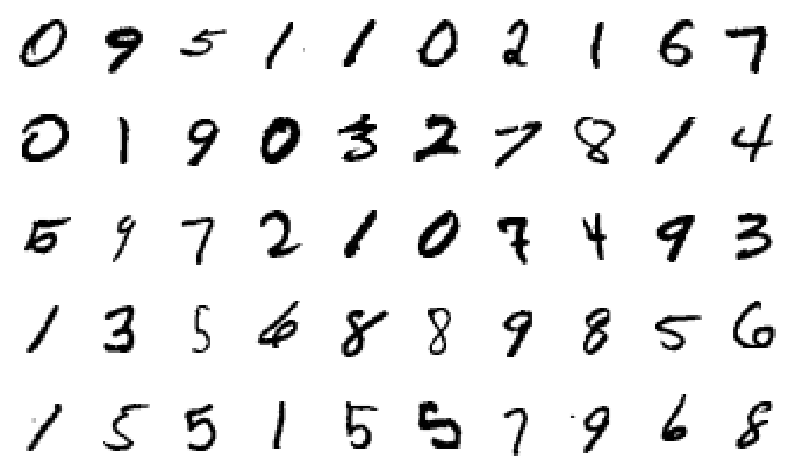

In [5]:
fig, ax = plt.subplots(5, 10, figsize=(10,6))
ax_flat = ax.ravel()

random_index = np.random.choice(np.arange(0, len(X)), 50, replace=False)
for i, index in enumerate(random_index):
    digit = X[index]
    digit = digit.reshape((28, 28))
    ax_flat[i].imshow(digit, cmap='binary', interpolation='nearest')
    ax_flat[i].axis('off')



# Modelling 

To start with we will just try out a few different modelling techniques and see if any work well with this dataset. First lets split the data into a training and test set and then write a function that can take a model and the data, fit the model, and report some evaluation metircs. The data is already split; the training set runs up to the 60,000 obsevration and everything thereafter is part of the test set.

Sklearn will automatically detect when you are using a binary classifier for a multilabel classification and will default to a OvA set of models. The confusion matrix displays the predicted for each of the ten classes.

Logisitic regression performs resonably well on this dataset with an accuracy of the 93%. This dataset is not suited to discriminant analysis with both linear and quadratic disriminant analysis performing very poorly. This is expected, discriminant analysis assumes the predictors are normally distributed random variables, this will not be case with the features in this dataset. We can't expect inflexible methods such as logistic regression, LDA or QDA to learn the complex relationships between features that represent a number

Notably the KNN algorithm performs exceptionally well, achieving an accuracy of 97% with the nneighbours parameter set to 3. Lets focus on optimising the performance of this model. There are three things we can do to improve the KNN peformance.

1. We can optimnise the value of K - the number of negihbours we consider to make a classification decision. We can use sklearns grid search class to do this.

2. Space based algorithms such as KNN suffer from the curse of dimensionality - as p get large relative to n it becomes very difficult to find observations close to each other in the p-dimensional space. Data augmentation can be used to address this. We can transform each image, using rotation or shifting, to artificially increase the number the observations.

3. We can scale the data, the features are currently scaled between 0-255, we could scale these values between 0-1, this will ensure features with larger ranges do not disproportionately influence the predicted class.



In [6]:
X_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
def fit_and_evaluate(model, X_train, X_test, y_train, y_test):
    
    #fit
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    #evaluate
    print(model.__repr__())
    print('Accuracy: ', accuracy_score(y_test, preds))
    print(confusion_matrix(y_test, preds))

    

In [8]:
fit_and_evaluate(LogisticRegression(), X_train, x_test, y_train, y_test)

LogisticRegression()
Accuracy:  0.9255
[[ 963    0    0    3    1    3    4    4    2    0]
 [   0 1112    4    2    0    1    3    2   11    0]
 [   3   10  926   15    6    4   15    8   42    3]
 [   4    1   21  916    1   26    3    9   22    7]
 [   1    1    7    3  910    0    9    7   10   34]
 [  11    2    1   33   11  776   11    6   35    6]
 [   9    3    7    3    7   16  910    2    1    0]
 [   1    6   24    5    7    1    0  951    3   30]
 [   8    7    6   23    6   26   10   10  869    9]
 [   9    7    0   11   25    6    0   22    7  922]]


c:\Users\caine\OneDrive\Documents\digit_recognition_app\dr_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
fit_and_evaluate(LDA(), X_train, x_test, y_train, y_test)

LinearDiscriminantAnalysis()
Accuracy:  0.873
[[ 940    0    1    4    2   13    9    1    9    1]
 [   0 1096    4    3    2    2    3    0   25    0]
 [  15   32  816   34   21    5   37    9   57    6]
 [   5    5   25  883    4   25    3   16   29   15]
 [   0   12    6    0  888    4    7    2   10   53]
 [   8    8    4   44   12  735   15   10   38   18]
 [  12    8   11    0   25   29  857    0   16    0]
 [   2   30   15    9   22    2    0  864    4   80]
 [   7   27    8   27   20   53   10    6  790   26]
 [   9    7    1   13   63    6    0   37   12  861]]


In [10]:
fit_and_evaluate(QDA(), X_train, x_test, y_train, y_test)

c:\Users\caine\OneDrive\Documents\digit_recognition_app\dr_env\Lib\site-packages\sklearn\discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()
Accuracy:  0.5364
[[ 949    1    1    6    0    1    8    1   12    1]
 [  20 1075    3    1    0    0   17    0   13    6]
 [ 502   11  180   92    4    0  148    3   79   13]
 [ 483   16    1  258    0    0   39    2  140   71]
 [ 248    7    6   10   89    1   55   10  170  386]
 [ 338    7    1   16    0   26   77    1  370   56]
 [  27    4    2    1    0    3  914    0    7    0]
 [  17    8    1   14    3    0    3  283   24  675]
 [ 106   56    2   10    1    7   43    4  629  116]
 [  19    8    2    4    1    0    1    9    4  961]]


In [11]:
fit_and_evaluate(KNeighborsClassifier(3), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=3)
Accuracy:  0.9705
[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [  10    9  996    2    0    0    0   13    2    0]
 [   0    2    4  976    1   13    1    7    3    3]
 [   1    6    0    0  950    0    4    2    0   19]
 [   6    1    0   11    2  859    5    1    3    4]
 [   5    3    0    0    3    3  944    0    0    0]
 [   0   21    5    0    1    0    0  991    0   10]
 [   8    2    4   16    8   11    3    4  914    4]
 [   4    5    2    8    9    2    1    8    2  968]]


In [12]:
fit_and_evaluate(KNeighborsClassifier(6), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=6)
Accuracy:  0.9677
[[ 975    1    1    0    0    1    1    1    0    0]
 [   0 1132    2    0    0    0    1    0    0    0]
 [  12   11  985    2    1    0    2   15    4    0]
 [   0    3    3  978    1   10    1    8    3    3]
 [   2    7    0    0  953    0    4    1    1   14]
 [   6    0    0   14    2  862    3    1    1    3]
 [   6    4    0    0    3    2  943    0    0    0]
 [   0   26    4    0    2    0    0  987    0    9]
 [   7    4    5   16    8   12    5    6  906    5]
 [   6    7    3    7   12    3    1   12    2  956]]


## Data augmentation

Lets first tackle data augmentation. Firstly, lets think about the kinds of transformations we want to make. We might expect that they will not drawn an image exactly in the middle of the canvas, they might draw it slightly to the left or right, or above or below the origin. To summarise, we want to right a function that can rotate the vector representation of our image and a function that can shift our image in the x,y plane. 

In [13]:
def shift_image(image:np.ndarray, offset:tuple[int]):
    """
    This function can shift the pixels in an image in the xy plane.
    The offset tuple specifies the number of pixels to move the image in the x and y direction.
    """
    shifted_image = np.roll(image, offset, (1, 0))
    return shifted_image



Lets test this function to make sure it is working as expected.

We can see that the function correctly shifts the image. Looking at the second example though we can see we do not want to shift the image too much, this causes the pixels at the bottom of the number to be rolled to the top of image. This would give use data that would not occur when a user is trying to draw an number and hence would harm the efficacy of the model.

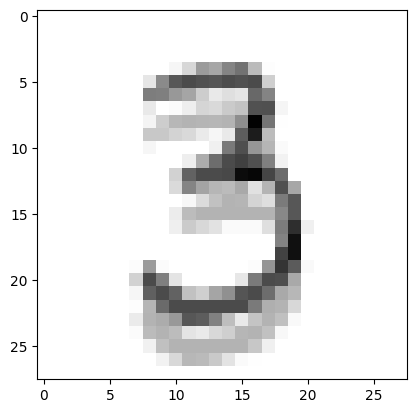

In [14]:
some_image = X_train[50]
some_image = some_image.reshape((28,28))
shifted_image = shift_image(some_image, (0, 3))

figure = plt.figure()
ax = figure.add_subplot()

ax.imshow(some_image, cmap='binary', interpolation='none', alpha=1)
ax.imshow(shifted_image, cmap='binary', interpolation='none', alpha=0.3)




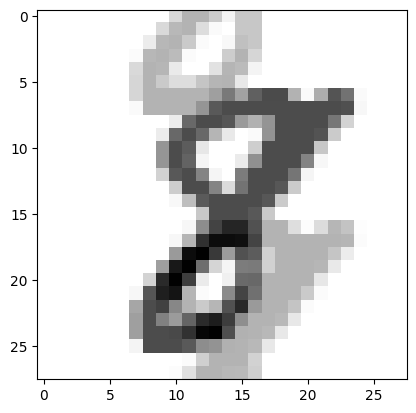

In [15]:
some_image = X_train[55]
some_image = some_image.reshape((28,28))
shifted_image = shift_image(some_image, (0, 10))

figure = plt.figure()
ax = figure.add_subplot()

ax.imshow(some_image, cmap='binary', interpolation='none', alpha=1)
ax.imshow(shifted_image, cmap='binary', interpolation='none', alpha=0.3)




Okay lets add these training images to our dataset. We will write a function called augment data that will create a new numpy array with all original 60,000 training images and an additional 240,000 augmented images.

In [16]:
def augment_data(images, labels):
    """
    Applies four transformations to each image in the training dataset by shifting each image 1 pixel left, right,
    up and down. 
    Returns the augmented image data and the augmented labels.
    """
    augmeted_images = []
    augemented_labels = []

    transformations = [(1,0), (-1,0), (0,1), (0,-1)]
    for i, img in enumerate(images):
        augmeted_images.append(img)
        augemented_labels.append(labels[i])
        for trns in transformations:
            shifted_image = shift_image(img.reshape(28, 28), trns)
            augmeted_images.append(shifted_image.reshape(784,))
            augemented_labels.append(labels[i])
    
    return np.array(augmeted_images), np.array(augemented_labels)





In [17]:
X_train, y_train = augment_data(X_train, y_train)

Lets see if this improves the KNN model.

In [18]:
fit_and_evaluate(KNeighborsClassifier(3), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=3)
Accuracy:  0.9756
[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   6    2 1006    2    1    0    2   12    1    0]
 [   0    2    4  983    1    9    0    5    4    2]
 [   1    6    0    0  951    0    4    2    0   18]
 [   2    2    0    9    0  868    5    1    3    2]
 [   7    4    0    0    2    2  943    0    0    0]
 [   0   19    3    1    3    0    0  995    0    7]
 [   6    0    4   12    4    9    2    4  930    3]
 [   1    7    1    6    7    4    1    8    1  973]]


A 0.5% increase in the overall accuracy rate!

# Scaling 

We can simply divide the pixel values by their maximum attainable value of 255 to scale this data

In [19]:
X_train = X_train / 255

In [20]:
x_test = x_test / 255

Lets see the impact of this

In [21]:
fit_and_evaluate(KNeighborsClassifier(3), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=3)
Accuracy:  0.9756
[[ 974    1    1    0    0    1    2    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   6    2 1006    2    1    0    2   12    1    0]
 [   0    2    4  983    1    9    0    5    4    2]
 [   1    6    0    0  951    0    4    2    0   18]
 [   2    2    0    9    0  868    5    1    3    2]
 [   7    4    0    0    2    2  943    0    0    0]
 [   0   19    3    1    3    0    0  995    0    7]
 [   6    0    4   12    4    9    2    4  930    3]
 [   1    7    1    6    7    4    1    8    1  973]]


There is no impact of this on the accuracy of the model - it does however vastly improve the convergence time of algorithm.

# Optimising K

We can use sklearns grid search to find the optimal value of K

Its taking too long to run the grid search! - This is a result of the data augmentation and the large number of features in the model. Lets just try a few different values of K

In [22]:
from sklearn.model_selection import GridSearchCV

In [30]:
parameters = {'n_neighbors':[i for i in range(1, 10, 1)]}
knn_clf = GridSearchCV(KNeighborsClassifier(), parameters, cv=3, n_jobs=3)
knn_clf.fit(X_train, y_train)


KeyboardInterrupt: 

In [31]:
fit_and_evaluate(KNeighborsClassifier(2), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=2)
Accuracy:  0.9697
[[ 977    1    1    0    0    0    0    1    0    0]
 [   0 1133    2    0    0    0    0    0    0    0]
 [   9    6 1003    1    1    0    2   10    0    0]
 [   1    2    6  990    1    3    0    3    3    1]
 [   1    6    1    0  960    0    3    1    0   10]
 [   3    4    0   20    1  857    2    1    2    2]
 [   8    4    0    0    2    5  939    0    0    0]
 [   0   25    5    0    6    0    0  986    0    6]
 [   7    2    6   23    5   21    7    5  896    2]
 [   4    7    1    7   12    6    0   13    3  956]]


In [32]:
fit_and_evaluate(KNeighborsClassifier(4), X_train, x_test, y_train, y_test)

KNeighborsClassifier(n_neighbors=4)
Accuracy:  0.9756
[[ 975    1    1    0    0    1    1    1    0    0]
 [   0 1132    2    0    0    0    0    0    0    1]
 [   6    4 1007    2    1    0    0   11    1    0]
 [   0    3    2  991    1    3    0    5    3    2]
 [   1    6    0    0  960    0    3    1    0   11]
 [   3    2    0   10    2  866    3    1    2    3]
 [   6    4    0    0    2    2  944    0    0    0]
 [   0   23    5    0    2    0    0  994    0    4]
 [   4    1    5   13    7   11    6    3  919    5]
 [   3    6    1    6    9    4    0   11    1  968]]


In [33]:
fit_and_evaluate(KNeighborsClassifier(5), X_train, x_test, y_train, y_test)


KNeighborsClassifier()
Accuracy:  0.9754
[[ 973    1    1    0    0    1    3    1    0    0]
 [   0 1132    2    0    1    0    0    0    0    0]
 [   6    6 1004    2    1    0    0   13    0    0]
 [   0    3    2  988    1    6    0    5    4    1]
 [   0    6    0    0  952    0    5    1    0   18]
 [   3    2    0    8    2  868    4    1    1    3]
 [   5    4    0    0    2    2  945    0    0    0]
 [   0   20    4    0    2    0    0  996    0    6]
 [   5    0    4    9    6   14    6    5  922    3]
 [   2    7    1    5    6    4    0    9    1  974]]


Values of K at 3 and 4 produce the highest accuracy. Given this we will go for the the most parsimonious model and use a value of K=3

## Saving the model

We will use joblib to pickle the trained KNN classifier. This will allow our fastAPI backend to load and utilise the trained model


In [34]:
knn_clf = KNeighborsClassifier(3)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=3)

In [36]:
import joblib as jb

jb.dump(knn_clf, r'C:\Users\caine\OneDrive\Documents\digit_recognition_app\fastapi-backend\models\knn_digit_classifier.pkl')

['C:\\Users\\caine\\OneDrive\\Documents\\digit_recognition_app\\fastapi-backend\\models\\knn_digit_classifier.pkl']

The pickle file for this model is actually too large to store on GitHub. Lets try to compress the file to get this down

In [37]:
import gzip

with open(r'C:\Users\caine\OneDrive\Documents\digit_recognition_app\fastapi-backend\models\knn_digit_classifier.pkl', 'rb') as f_in:
    with gzip.open(r'C:\Users\caine\OneDrive\Documents\digit_recognition_app\fastapi-backend\models\knn_digit_classifier.pkl.gz', 'wb') as f_out:
        f_out.writelines(f_in)
    

In [40]:
import os

os.path.getsize(r'C:\Users\caine\OneDrive\Documents\digit_recognition_app\fastapi-backend\models\knn_digit_classifier.pkl.gz') /1024**2

31.381174087524414

Okay that has worked ! - lets push the model to github